In [162]:
import pandas as pd
pd.options.display.max_columns=200
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.pipeline import make_pipeline
import bs4 as bs
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from wordcloud import WordCloud
from PIL import Image
from pandarallel import pandarallel
import re

In [2]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import glob


#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

2023-04-19 09:57:34.065140: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-19 09:57:34.180743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 09:57:34.622696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-19 09:57:34.949256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

In [170]:
data_bow = pd.read_csv('data/data_bow.csv')

In [171]:
data_bow.head()

,Id,Body,Title,Tags,text
0,40101130,consider pd.series import panda import numpy n...,calculate rolling idxmax,<python><pandas><numpy><dataframe><series>,calculate rolling idxmax consider pd.series...
1,662383,'ve using time substring str_col patindex str_...,better technique trimming leading zero sql server,<sql><sql-server><sql-server-2005><tsql><string>,better technique trimming leading zero sql ser...
2,662421,trying install java application linux machine ...,x11 display variable mean,<java><linux><variables><x11><headless>,x11 display variable mean trying install ja...
3,3520133,library allows easily conveniently create obje...,object oriented callback,<c++><oop><callback><pointer-to-member><eiffel>,object oriented callback library allows eas...
4,1396164,edit whole question unclear want use openssl.n...,why n't .net find openssl.net dll,<c#><.net><dll><dllimport><dllnotfoundexception>,why n't .net find openssl.net dll edit whol...


In [172]:
# Suppression des chevrons et extraction des tags
data_bow['Tags'] = data_bow['Tags'].apply(lambda x: re.findall(r'<([^>]+)>', x))

data_bow.head()

,Id,Body,Title,Tags,text
0,40101130,consider pd.series import panda import numpy n...,calculate rolling idxmax,"[python, pandas, numpy, dataframe, series]",calculate rolling idxmax consider pd.series...
1,662383,'ve using time substring str_col patindex str_...,better technique trimming leading zero sql server,"[sql, sql-server, sql-server-2005, tsql, string]",better technique trimming leading zero sql ser...
2,662421,trying install java application linux machine ...,x11 display variable mean,"[java, linux, variables, x11, headless]",x11 display variable mean trying install ja...
3,3520133,library allows easily conveniently create obje...,object oriented callback,"[c++, oop, callback, pointer-to-member, eiffel]",object oriented callback library allows eas...
4,1396164,edit whole question unclear want use openssl.n...,why n't .net find openssl.net dll,"[c#, .net, dll, dllimport, dllnotfoundexception]",why n't .net find openssl.net dll edit whol...


In [173]:
#Split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_bow[['Title','Body','text']], data_bow[['Tags']], test_size=0.2, random_state=42)

In [174]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.9, min_df=2)
ctf = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2)

feat = 'Title'
cv_fit = cvect.fit(X_train[feat])
ctf_fit = ctf.fit(X_train[feat])

cv_transform_title = cv_fit.transform(X_train['Title'])
ctf_transform_title = ctf.transform(X_train['Title'])

cv_transform_text = cvect.transform(X_train['text'])
ctf_transform_text = ctf.transform(X_train['text'])

In [175]:
cv_transform_title.shape, ctf_transform_title.shape

((40000, 9073), (40000, 9073))

In [176]:
cv_transform_text.shape, ctf_transform_text.shape

((40000, 9073), (40000, 9073))

In [177]:
#type of cv_transform_title
type(cv_transform_title)

scipy.sparse._csr.csr_matrix

In [178]:
cv_fit.vocabulary_.get('python')

6209

In [179]:
#Classement des mots les plus fréquents

cv_sum = cv_transform_title.sum(axis=0)
cv_words_freq = [(word, cv_sum[0, idx]) for word, idx in cv_fit.vocabulary_.items()]
cv_words_freq =sorted(cv_words_freq, key = lambda x: x[1], reverse=True)
cv_words_freq[:10]

[('using', 3088),
 ('file', 2062),
 ('use', 1531),
 ('error', 1483),
 ('net', 1477),
 ('android', 1367),
 ('java', 1296),
 ('python', 1279),
 ('data', 1051),
 ('window', 987)]

In [180]:
"""def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words_titles = gen_words(X_train['Title'])

print (data_words_titles[0:5])"""

"def gen_words(texts):\n    final = []\n    for text in texts:\n        new = gensim.utils.simple_preprocess(text, deacc=True)\n        final.append(new)\n    return (final)\n\ndata_words_titles = gen_words(X_train['Title'])\n\nprint (data_words_titles[0:5])"

In [181]:
"""data_words = gen_words(X_train['text'])
print (data_words[0][0:20])"""

"data_words = gen_words(X_train['text'])\nprint (data_words[0][0:20])"

In [14]:
from gensim.matutils import Sparse2Corpus

gensim_corpus_title_cv = Sparse2Corpus(cv_transform_title, documents_columns=False)
gensim_corpus_text_cv = Sparse2Corpus(cv_transform_text, documents_columns=False)
gensim_corpus_title_ctf = Sparse2Corpus(ctf_transform_title, documents_columns=False)
gensim_corpus_text_ctf = Sparse2Corpus(ctf_transform_text, documents_columns=False)

In [15]:
id2word_title_cv = {v: k for k, v in cv_fit.vocabulary_.items()}
id2word_title_cv = gensim.corpora.Dictionary.from_corpus(gensim_corpus_title_cv, id2word=id2word_title_cv)

id2word_text_cv = {v: k for k, v in cv_fit.vocabulary_.items()}
id2word_text_cv = gensim.corpora.Dictionary.from_corpus(gensim_corpus_text_cv, id2word=id2word_text_cv)

id2word_title_ctf = {v: k for k, v in ctf_fit.vocabulary_.items()}
id2word_title_ctf = gensim.corpora.Dictionary.from_corpus(gensim_corpus_title_ctf, id2word=id2word_title_ctf)

id2word_text_ctf = {v: k for k, v in ctf_fit.vocabulary_.items()}
id2word_text_ctf = gensim.corpora.Dictionary.from_corpus(gensim_corpus_text_ctf, id2word=id2word_text_ctf)

In [66]:
def convert_corpus_to_texts(corpus, id2word):
    texts = []
    for doc in corpus:
        text = [id2word[word_id] for word_id, freq in doc]
        texts.append(text)
    return texts

converted_title_cv = convert_corpus_to_texts(gensim_corpus_title_cv, id2word_title_cv)
converted_title_ctf = convert_corpus_to_texts(gensim_corpus_title_ctf, id2word_title_ctf)
converted_text_cv = convert_corpus_to_texts(gensim_corpus_text_cv, id2word_text_cv)
converted_text_ctf = convert_corpus_to_texts(gensim_corpus_text_ctf, id2word_text_ctf)

In [16]:
lda_model_title_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_cv,
                                           id2word=id2word_title_cv,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [17]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_title_cv, gensim_corpus_title_cv, id2word_title_cv, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.013189  0.073674       1        1  13.625223
0      0.050101 -0.411528       2        1  12.317752
1     -0.365935 -0.135630       3        1  11.954182
2     -0.224896  0.382459       4        1  10.323693
8      0.332474 -0.312146       5        1  10.078504
6      0.398604 -0.039892       6        1   9.949812
3      0.099662  0.441695       7        1   9.736800
7     -0.242471 -0.382504       8        1   8.430208
4     -0.426232  0.136357       9        1   7.832143
5      0.365504  0.247515      10        1   5.751682, topic_info=          Term         Freq        Total Category  logprob  loglift
3        using  3264.000000  3264.000000  Default  30.0000  30.0000
30        file  1752.000000  1752.000000  Default  29.0000  29.0000
21         net  1500.000000  1500.000000  Default  28.0000  28.0000
306        use  1767.000000  1767.000000  Default  27.0000  27.0000
75     android  1460.000000  1460.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
318   expected   110.720640   111.676189  Topic10  -4.7373   2.8471
547   datetime   101.498125   102.453541  Topic10  -4.8242   2.8463
2186     basic   100.194611   101.150163  Topic10  -4.8372   2.8462
1363     clang    99.471989   100.427407  Topic10  -4.8444   2.8461
984     effect    91.665935    92.621393  Topic10  -4.9261   2.8453

[330 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
80        2  0.999076   access
155       5  0.998660      add
750      10  0.995133  address
1315      8  0.996806     ajax
75        7  0.999515  android
...     ...       ...      ...
460       5  0.997788  working
131       2  0.997609      wpf
224       7  0.998402    write
127       3  0.998535    xcode
410       1  0.997158      xml

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 2, 3, 9, 7, 4, 8, 5, 6])

In [58]:
coherence_score_title_cv = CoherenceModel(model=lda_model_title_cv, texts=converted_texts_title_cv, dictionary=id2word_title_cv, coherence='c_v')
coherence_score_title_cv.get_coherence()

0.29037707112940336

In [19]:
lda_model_title_ctf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_ctf,
                                                id2word=id2word_title_ctf,
                                                num_topics=20,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_title_ctf, gensim_corpus_title_ctf, id2word_title_ctf, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.291416  0.339230       1        1  10.763669
13     0.146553 -0.352487       2        1   6.522852
17    -0.284169 -0.240220       3        1   6.413036
18    -0.131126  0.343944       4        1   6.255312
0      0.284231 -0.248171       5        1   6.083145
15     0.336859 -0.104414       6        1   6.017714
11     0.064535  0.359856       7        1   5.852930
8     -0.162545 -0.342275       8        1   5.475837
6     -0.361183  0.112668       9        1   5.444363
3      0.256337  0.155696      10        1   5.364772
1      0.348602  0.040471      11        1   5.230650
10     0.027428  0.221702      12        1   4.828370
16    -0.339504 -0.091733      13        1   4.676221
5     -0.245600  0.234535      14        1   4.255870
19    -0.006179 -0.303884      15        1   3.784543
7     -0.108824  0.083127      16        1   3.539987
9     -0.004142 -0.164774      17        1   3.362597
2     -0.208198 -0.010152      18        1   2.897137
12     0.103870 -0.030338      19        1   2.773277
4     -0.008359 -0.002780      20        1   0.457717, topic_info=         Term         Freq        Total Category  logprob  loglift
3       using  2090.000000  2090.000000  Default  30.0000  30.0000
306       use  1278.000000  1278.000000  Default  29.0000  29.0000
30       file  1301.000000  1301.000000  Default  28.0000  28.0000
96     python  1087.000000  1087.000000  Default  27.0000  27.0000
75    android  1145.000000  1145.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1041     node     0.032206     2.581701  Topic20  -9.4414   1.0026
451       run     0.032206     2.582903  Topic20  -9.4414   1.0022
542      code     0.032206     2.582865  Topic20  -9.4414   1.0022
617    custom     0.032206     2.582252  Topic20  -9.4414   1.0024
1291    video     0.032206     2.581657  Topic20  -9.4414   1.0026

[1144 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
200      16  0.932698   abstract
80        1  0.993874     access
155      10  0.993497        add
262       9  0.906073     advice
27       15  0.979760  algorithm
...     ...       ...        ...
131      15  0.991435        wpf
224       4  0.993143      write
127      14  0.990028      xcode
410      17  0.987999        xml
361      18  0.962320       zoom

[250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 18, 19, 1, 16, 12, 9, 7, 4, 2, 11, 17, 6, 20, 8, 10, 3, 13, 5])

In [62]:
coherence_score_title_ctf = CoherenceModel(model=lda_model_title_ctf, texts=converted_title_ctf, dictionary=id2word_title_ctf, coherence='c_v')
coherence_score_title_ctf.get_coherence()

0.3888885132931495

In [63]:
lda_model_text_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_text_cv,
                                                id2word=id2word_text_cv,
                                                num_topics=10,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

In [64]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_text_cv, gensim_corpus_text_cv, id2word_text_cv, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.404660  0.094586       1        1  20.922577
2     -0.015618  0.146567       2        1  12.972136
7     -0.221469  0.328038       3        1  12.666011
0      0.197741 -0.177941       4        1  11.431670
8      0.433992 -0.084412       5        1   9.312802
6      0.337073  0.238289       6        1   8.939966
9      0.087998  0.448042       7        1   7.063330
3      0.124459 -0.473558       8        1   5.813828
1     -0.405904 -0.252008       9        1   5.587720
4     -0.133613 -0.267603      10        1   5.289961, topic_info=         Term          Freq         Total Category  logprob  loglift
67       java  27840.000000  27840.000000  Default  30.0000  30.0000
30       file  26498.000000  26498.000000  Default  29.0000  29.0000
696       org  20061.000000  20061.000000  Default  28.0000  28.0000
75    android  21631.000000  21631.000000  Default  27.0000  27.0000
257    string  21865.000000  21865.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
4706      yes   1167.870950   1844.170997  Topic10  -5.1706   2.4825
117      size   1664.586591   6944.948377  Topic10  -4.8162   1.5109
295    import   1345.486160  11354.072385  Topic10  -5.0290   0.8065
659       var   1247.184430  10712.449937  Topic10  -5.1049   0.7888
902    return   1198.349501  19670.440286  Topic10  -5.1448   0.1412

[539 rows x 6 columns], token_table=      Topic      Freq Term
term                      
7945      3  0.999908   00
1798      9  0.998811   04
2263      8  0.049168   10
2263      9  0.950843   10
3143      9  0.999801   12
...     ...       ...  ...
5686      8  0.998225  xsd
4856      4  0.999560  xxx
4706      1  0.259737  yes
4706      9  0.106823  yes
4706     10  0.633347  yes

[869 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 8, 1, 9, 7, 10, 4, 2, 5])

In [67]:
CoherenceModel(model=lda_model_text_cv, texts=converted_text_cv, dictionary=id2word_text_cv, coherence='c_v').get_coherence()

0.5527363911348151

In [68]:
lda_model_text_ctf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_text_ctf,
                                                id2word=id2word_text_ctf,
                                                num_topics=10,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

In [69]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_text_ctf, gensim_corpus_text_ctf, id2word_text_ctf, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.303965 -0.297015       1        1  38.026570
3      0.068115 -0.446536       2        1  33.246386
2     -0.443065  0.046280       3        1  18.907944
0     -0.188773  0.395131       4        1   3.971293
1      0.333772 -0.142528       5        1   1.509269
7      0.339397  0.122963       6        1   1.289681
4      0.161162  0.311392       7        1   1.234095
9      0.014175 -0.149114       8        1   1.011319
6     -0.057564  0.125347       9        1   0.633256
5      0.076746  0.034080      10        1   0.170186, topic_info=            Term        Freq       Total Category  logprob  loglift
471          com  694.000000  694.000000  Default  30.0000  30.0000
49        server  540.000000  540.000000  Default  29.0000  29.0000
367         date  199.000000  199.000000  Default  28.0000  28.0000
67          java  513.000000  513.000000  Default  27.0000  27.0000
58         class  924.000000  924.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
8663    difftool    0.027746    1.019840  Topic10  -9.4367   2.7717
9044  routerlink    0.027765    1.092757  Topic10  -9.4361   2.7033
8672        6379    0.027820    1.352736  Topic10  -9.4341   2.4919
1408     polymer    0.027832    3.063601  Topic10  -9.4336   1.6749
8634         lan    0.027785    1.394309  Topic10  -9.4353   2.4604

[462 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2088      9  0.975122      000
1958      3  0.995724      100
6307      9  0.952397      127
1083      5  0.984793     2008
4155      8  0.951802     2009
...     ...       ...      ...
98        1  0.857563     work
98        2  0.140775     work
460       2  0.998293  working
131       9  0.993659      wpf
3279      3  0.996219      www

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 3, 1, 2, 8, 5, 10, 7, 6])

In [70]:
CoherenceModel(model=lda_model_text_ctf, texts=converted_text_ctf, dictionary=id2word_text_ctf, coherence='c_v').get_coherence()

0.3242731928676607

In [80]:
"""lda_models_title_cv = {}  # Initialise un dictionnaire vide.

for i in range(5, 25):
    lda_model_title_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_cv,
                                                id2word=id2word_title_cv,
                                                num_topics=i,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

    # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé
    lda_models_title_cv[i] = lda_model_title_cv
    lda_model_title_cv.save('models/lda_model_title_cv_{}.model'.format(i))"""

In [82]:
#load model from disk
lda_model_title_cv = {}
for i in range(5, 25):
      lda_model_title_cv[i] = gensim.models.ldamodel.LdaModel.load('models/lda_model_title_cv_{}.model'.format(i))

coherence_values_title_cv = {}
for i in range(5, 25):
      coherence_values_title_cv[i] = CoherenceModel(model=lda_model_title_cv[i], texts=converted_title_cv, dictionary=id2word_title_cv, coherence='c_v').get_coherence()

for m, cv in coherence_values_title_cv.items():
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2152
Num Topics = 6  has Coherence Value of 0.2375
Num Topics = 7  has Coherence Value of 0.2429
Num Topics = 8  has Coherence Value of 0.2501
Num Topics = 9  has Coherence Value of 0.2732
Num Topics = 10  has Coherence Value of 0.2904
Num Topics = 11  has Coherence Value of 0.3137
Num Topics = 12  has Coherence Value of 0.3227
Num Topics = 13  has Coherence Value of 0.3294
Num Topics = 14  has Coherence Value of 0.3544
Num Topics = 15  has Coherence Value of 0.3415
Num Topics = 16  has Coherence Value of 0.4001
Num Topics = 17  has Coherence Value of 0.4249
Num Topics = 18  has Coherence Value of 0.4211
Num Topics = 19  has Coherence Value of 0.3907
Num Topics = 20  has Coherence Value of 0.3898
Num Topics = 21  has Coherence Value of 0.3875
Num Topics = 22  has Coherence Value of 0.3967
Num Topics = 23  has Coherence Value of 0.4254
Num Topics = 24  has Coherence Value of 0.3854


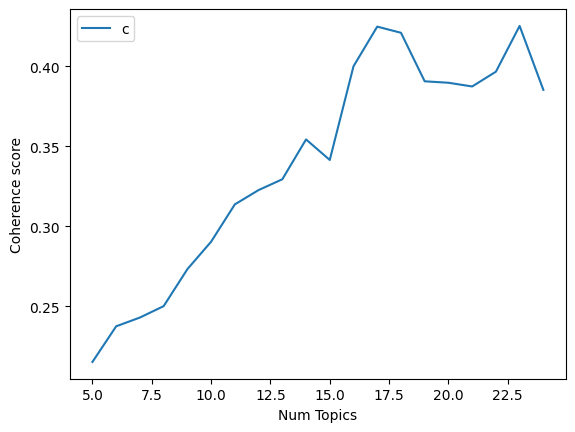

In [83]:
# Show graph
limit=25; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, list(coherence_values_title_cv.values()))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [84]:
"""lda_models_title_ctf = {}  # Initialise un dictionnaire vide.

for i in range(5, 25):
      lda_model_title_ctf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_ctf,
                                                      id2word=id2word_title_ctf,
                                                      num_topics=i,
                                                      random_state=100,
                                                      update_every=1,
                                                      chunksize=100,
                                                      passes=10,
                                                      alpha="auto")
      
      # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé
      lda_models_title_ctf[i] = lda_model_title_ctf
      lda_model_title_ctf.save('models/lda_model_title_ctf_{}.model'.format(i))"""

In [85]:
#load model from disk
lda_model_title_ctf = {}
for i in range(5, 25):
      lda_model_title_ctf[i] = gensim.models.ldamodel.LdaModel.load('models/lda_model_title_ctf_{}.model'.format(i))

coherence_values_title_ctf = {}
for i in range(5, 25):
      coherence_values_title_ctf[i] = CoherenceModel(model=lda_model_title_ctf[i], texts=converted_title_ctf, dictionary=id2word_title_ctf, coherence='c_v').get_coherence()

for m, cv in coherence_values_title_ctf.items():
      print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2194
Num Topics = 6  has Coherence Value of 0.284
Num Topics = 7  has Coherence Value of 0.2557
Num Topics = 8  has Coherence Value of 0.2945
Num Topics = 9  has Coherence Value of 0.3622
Num Topics = 10  has Coherence Value of 0.3086
Num Topics = 11  has Coherence Value of 0.352
Num Topics = 12  has Coherence Value of 0.3588
Num Topics = 13  has Coherence Value of 0.3515
Num Topics = 14  has Coherence Value of 0.3592
Num Topics = 15  has Coherence Value of 0.4441
Num Topics = 16  has Coherence Value of 0.4528
Num Topics = 17  has Coherence Value of 0.4084
Num Topics = 18  has Coherence Value of 0.3731
Num Topics = 19  has Coherence Value of 0.3673
Num Topics = 20  has Coherence Value of 0.3889
Num Topics = 21  has Coherence Value of 0.3417
Num Topics = 22  has Coherence Value of 0.3528
Num Topics = 23  has Coherence Value of 0.3552
Num Topics = 24  has Coherence Value of 0.3375


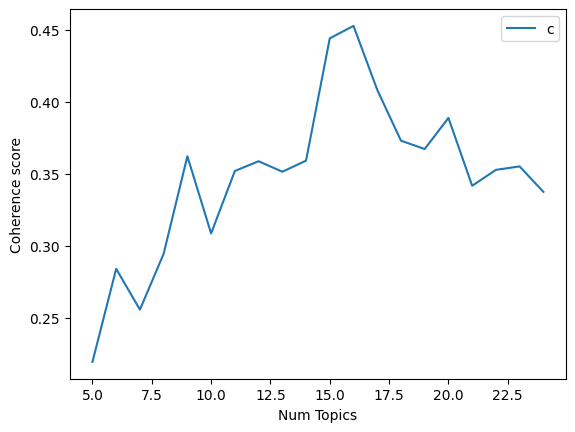

In [86]:
# Show graph
limit=25; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, list(coherence_values_title_ctf.values()))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
"""lda_models_text_cv = {}  # Initialise un dictionnaire vide.

for i in range(5, 25):
    lda_model_text_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_text_cv,
                                                id2word=id2word_text_cv,
                                                num_topics=i,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

    # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé
    lda_models_text_cv[i] = lda_model_text_cv
    lda_model_text_cv.save('models/lda_model_text_cv_{}.model'.format(i))"""

In [73]:
#load models from disk
lda_models_text_cv = {}
for i in range(5, 25):
      lda_models_text_cv[i] = gensim.models.ldamodel.LdaModel.load('models/lda_model_text_cv_{}.model'.format(i))

In [72]:
coherence_values_text_cv = []
for i in range(5, 25):
      model = lda_models_text_cv[i]
      coherence_model = CoherenceModel(model=model, texts=converted_text_cv, dictionary=id2word_text_cv, coherence='c_v')
      coherence_values_text_cv.append(coherence_model.get_coherence())

In [74]:
for m, cv in zip(range(5, 25), coherence_values_text_cv):
      print("Num Topics =", m, "has Coherence Value of", round(cv, 4))

Num Topics = 5 has Coherence Value of 0.5055
Num Topics = 6 has Coherence Value of 0.5215
Num Topics = 7 has Coherence Value of 0.5002
Num Topics = 8 has Coherence Value of 0.5669
Num Topics = 9 has Coherence Value of 0.5229
Num Topics = 10 has Coherence Value of 0.5527
Num Topics = 11 has Coherence Value of 0.5377
Num Topics = 12 has Coherence Value of 0.5235
Num Topics = 13 has Coherence Value of 0.5478
Num Topics = 14 has Coherence Value of 0.5123
Num Topics = 15 has Coherence Value of 0.5284
Num Topics = 16 has Coherence Value of 0.55
Num Topics = 17 has Coherence Value of 0.5046
Num Topics = 18 has Coherence Value of 0.5071
Num Topics = 19 has Coherence Value of 0.513
Num Topics = 20 has Coherence Value of 0.4887
Num Topics = 21 has Coherence Value of 0.5078
Num Topics = 22 has Coherence Value of 0.4898
Num Topics = 23 has Coherence Value of 0.4779
Num Topics = 24 has Coherence Value of 0.4832


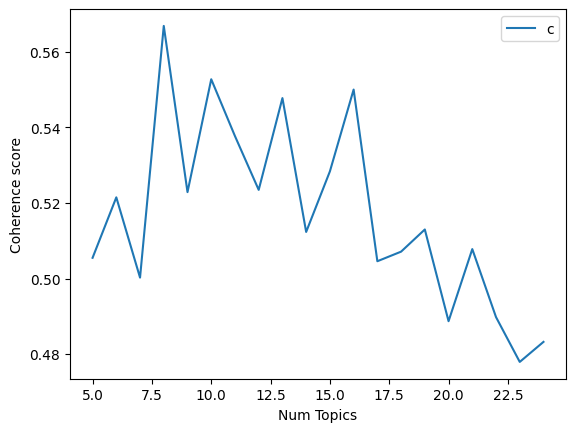

In [77]:
#plot coherence score
x = range(5, 25)
plt.plot(x, coherence_values_text_cv)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [78]:
"""lda_models_text_ctf = {}  # Initialise un dictionnaire vide.

for i in range(5, 25):
    lda_model_text_ctf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_text_ctf,
                                                id2word=id2word_text_ctf,
                                                num_topics=i,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

    # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé
    lda_models_text_ctf[i] = lda_model_text_ctf
    lda_model_text_ctf.save('models/lda_model_text_ctf_{}.model'.format(i))"""

Num Topics = 5 has Coherence Value of 0.3401
Num Topics = 6 has Coherence Value of 0.3482
Num Topics = 7 has Coherence Value of 0.2919
Num Topics = 8 has Coherence Value of 0.3952
Num Topics = 9 has Coherence Value of 0.2927
Num Topics = 10 has Coherence Value of 0.3243
Num Topics = 11 has Coherence Value of 0.2912
Num Topics = 12 has Coherence Value of 0.2858
Num Topics = 13 has Coherence Value of 0.3047
Num Topics = 14 has Coherence Value of 0.29
Num Topics = 15 has Coherence Value of 0.2579
Num Topics = 16 has Coherence Value of 0.2711
Num Topics = 17 has Coherence Value of 0.2845
Num Topics = 18 has Coherence Value of 0.2776
Num Topics = 19 has Coherence Value of 0.2692
Num Topics = 20 has Coherence Value of 0.267
Num Topics = 21 has Coherence Value of 0.2799
Num Topics = 22 has Coherence Value of 0.2831
Num Topics = 23 has Coherence Value of 0.2665
Num Topics = 24 has Coherence Value of 0.2738


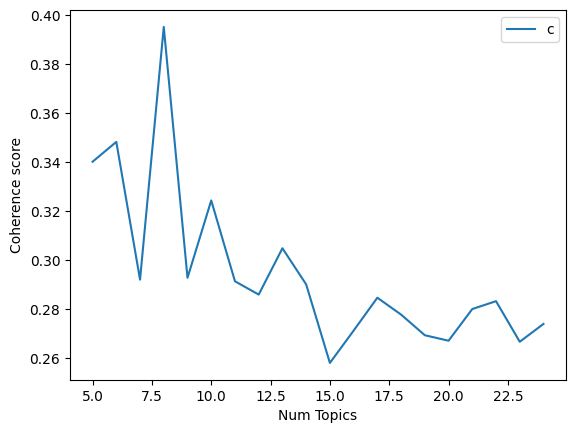

In [79]:
#load models from disk
lda_models_text_ctf = {}
for i in range(5, 25):
      lda_models_text_ctf[i] = gensim.models.ldamodel.LdaModel.load('models/lda_model_text_ctf_{}.model'.format(i))


coherence_values_text_ctf = []
for i in range(5, 25):
      model = lda_models_text_ctf[i]
      coherence_model = CoherenceModel(model=model, texts=converted_text_ctf, dictionary=id2word_text_ctf, coherence='c_v')
      coherence_values_text_ctf.append(coherence_model.get_coherence())


for m, cv in zip(range(5, 25), coherence_values_text_ctf):
      print("Num Topics =", m, "has Coherence Value of", round(cv, 4))



#plot coherence score
x = range(5, 25)
plt.plot(x, coherence_values_text_ctf)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [93]:
lda_model = lda_models_text_cv[16]

In [94]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, gensim_corpus_text_cv, id2word_text_cv)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.078987 -0.032254       1        1  20.681516
2      0.211808  0.042855       2        1  10.256101
1     -0.008333 -0.197659       3        1   8.212161
5      0.212753 -0.017405       4        1   7.300792
15    -0.094705  0.040188       5        1   6.142658
10     0.122745  0.204220       6        1   5.257794
14    -0.067047 -0.186303       7        1   4.999297
3     -0.064769  0.211821       8        1   4.951442
4      0.064826 -0.001867       9        1   4.748618
8     -0.193642  0.109200      10        1   4.701222
12    -0.193338 -0.089440      11        1   4.447115
7      0.031049  0.066800      12        1   4.438121
6     -0.107157  0.184923      13        1   3.816464
9      0.247104 -0.088979      14        1   3.676304
13    -0.064185 -0.215708      15        1   3.295149
0     -0.176096 -0.030392      16        1   3.075247, topic_info=            Term          Freq         Total Category  logprob  loglift
67          java  36503.000000  36503.000000  Default  30.0000  30.0000
30          file  35183.000000  35183.000000  Default  29.0000  29.0000
52         error  31850.000000  31850.000000  Default  28.0000  28.0000
75       android  25313.000000  25313.000000  Default  27.0000  27.0000
197         data  27093.000000  27093.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
2680     handler    971.767213   2421.724909  Topic16  -4.8120   2.5687
14        native   1078.516146   3610.506526  Topic16  -4.7078   2.2735
696          org   1770.688899  24859.897455  Topic16  -4.2120   0.8399
423         core   1248.915065   6782.866744  Topic16  -4.5611   1.7897
811   annotation   1003.341180   2796.421830  Topic16  -4.7800   2.4568

[772 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7945     12  0.999851       00
2088     12  0.998364      000
1798      3  0.999315       04
2263     11  0.936420       10
2263     12  0.020032       10
...     ...       ...      ...
8487     10  0.722224    xmlns
8487     13  0.277608    xmlns
5686     10  0.999094      xsd
4856      5  0.999353      xxx
2036      8  0.995611  youtube

[1097 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 3, 2, 6, 16, 11, 15, 4, 5, 9, 13, 8, 7, 10, 14, 1])

In [95]:
Mtopics_words = lda_model.get_topics()

In [98]:
Mtopics_words.shape

(16, 9073)

In [113]:
Mtrain_quest_topics = [lda_model.get_document_topics(doc) for doc in gensim_corpus_text_cv]

In [114]:
Mtrain_quest_topics_matrix = np.zeros((len(Mtrain_quest_topics), lda_model.num_topics))

for i, doc_topics in enumerate(Mtrain_quest_topics):
    for topic, prob in doc_topics:
        Mtrain_quest_topics_matrix[i, topic] = prob

Mtrain_quest_words = np.dot(Mtrain_quest_topics_matrix, Mtopics_words)

In [139]:
cv_transform_text_test = cv_fit.transform(X_test['text'])
gensim_corpus_text_test = Sparse2Corpus(cv_transform_text_test, documents_columns=False)

In [117]:
Mtest_quest_topics = [lda_model.get_document_topics(doc) for doc in gensim_corpus_text_test]

In [118]:
Mtest_quest_topics_matrix = np.zeros((len(Mtest_quest_topics), lda_model.num_topics))

for i, doc_topics in enumerate(Mtest_quest_topics):
    for topic, prob in doc_topics:
        Mtest_quest_topics_matrix[i, topic] = prob

Mtest_quest_words = np.dot(Mtest_quest_topics_matrix, Mtopics_words)

In [119]:
threshold = 0.01
Mtrain_quest_words[Mtrain_quest_words < threshold] = 0
Mtest_quest_words[Mtest_quest_words < threshold] = 0

In [120]:
topic_word_matrix = lda_model.get_topics()
topic_word_df = pd.DataFrame(topic_word_matrix, columns=cv_fit.get_feature_names_out())

In [123]:
train_quest_topics = lda_model.get_document_topics(gensim_corpus_text_cv, minimum_probability=0)
train_quest_topics_matrix = np.zeros((len(X_train), lda_model.num_topics))

for i, topic_probs in enumerate(train_quest_topics):
    for topic, prob in topic_probs:
        train_quest_topics_matrix[i, topic] = prob

train_quest_topics_df = pd.DataFrame(train_quest_topics_matrix)


In [124]:
test_quest_topics = lda_model.get_document_topics(gensim_corpus_text_test, minimum_probability=0)
test_quest_topics_matrix = np.zeros((len(X_test), lda_model.num_topics))

for i, topic_probs in enumerate(test_quest_topics):
    for topic, prob in topic_probs:
        test_quest_topics_matrix[i, topic] = prob

test_quest_topics_df = pd.DataFrame(test_quest_topics_matrix)

In [126]:
topics_words_matrix = lda_model.get_topics()
train_quest_words_matrix = np.matmul(train_quest_topics_df, topics_words_matrix)
test_quest_words_matrix = np.matmul(test_quest_topics_df, topics_words_matrix)

In [128]:
n_top_words = 5
train_quest_words_matrix_np = train_quest_words_matrix.to_numpy()
test_quest_words_matrix_np = test_quest_words_matrix.to_numpy()

train_keywords_indices = train_quest_words_matrix_np.argsort(axis=1)[:, -n_top_words:]
test_keywords_indices = test_quest_words_matrix_np.argsort(axis=1)[:, -n_top_words:]

In [129]:
train_keywords = [[id2word_text_cv[i] for i in keyword_indices] for keyword_indices in train_keywords_indices]
test_keywords = [[id2word_text_cv [i] for i in keyword_indices] for keyword_indices in test_keywords_indices]

In [132]:
import random

def display_keywords(questions, keywords, num_samples=10):
    sample_indices = random.sample(range(len(questions)), num_samples)
    for idx in sample_indices:
        print("Question:", questions.iloc[idx])
        print("Mots-clés:", keywords[idx])
        print("\n")

# Vérifier les mots-clés pour l'ensemble d'entraînement
print("Échantillon de l'ensemble d'entraînement :\n")
display_keywords(X_train['text'], train_keywords)


Échantillon de l'ensemble d'entraînement :

Question: what difference getch getchar    what exact difference getch getchar function
Mots-clés: ['var', 'time', 'test', 'function', 'value']


Question: how make textview drag linearlayout smooth android    situation able fix hopefully get advises the situation simple linearlayout textview multiple line text the user able drag textview around find position like what really important textview partially linearlayout appear cut here code sample linearlayout android layout_width= wrap_content android layout_height= wrap_content android layout_gravity= top|center_horizontal android clipchildren= false android gravity= center_horizontal|center_vertical android orientation= vertical textview android layout_width= fill_parent android layout_height= wrap_content android gravity= center android textcolor= color text_color android textsize= 16sp linearlayout see linearlayout clipchildren false allow cutoff text for textview set touch listener txt.set

In [133]:
# Vérifier les mots-clés pour l'ensemble de test
print("Échantillon de l'ensemble de test :\n")
display_keywords(X_test['text'], test_keywords)

Échantillon de l'ensemble de test :

Question: simple example how use buckminster    n't understand buckminster let say project need log4j junit4 how get started need specify dependency dependency added classpath eclipse tutorial show done
Mots-clés: ['code', 'like', 'use', 'org', 'using']


Question: webgrid column format issue mvc3    've trying change format single column webgrid without much success said column grid.column columnname emailaddress header email address format item html.emaillink item.emailaddress item.emailaddress cansort false the error the best overloaded method match 'system.web.helpers.webgrid.column string string system.func string bool invalid argument confused method signature match also change column work without error grid.column columnname emailaddress header email address format item new htmlstring string.format href=\ mailto class=\ item.emailaddress item.emailaddress cansort false for reference emaillink basic htmlhelper extension method public static ih

In [183]:
y_train.head()

,Tags
39087,"[r, customization, text-mining, tm, punctuation]"
30893,"[windows, batch-file, debugging, cmd, dos]"
45278,"[python, datetime, timezone, utc, pytz]"
16398,"[windows, node.js, macos, meteor, native]"
13653,"[c#, .net, performance, remoting, .net-remoting]"


In [184]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Encodage des tags
mlb = MultiLabelBinarizer()
y_train_encoded = mlb.fit_transform(y_train['Tags'])
y_test_encoded = mlb.transform(y_test['Tags'])

# Utilisation de représentation de texte
X_train_vectorized = cv_transform_text
X_test_vectorized = cv_transform_text_test

# Entraînement du modèle One-vs-Rest
base_classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
ovr_classifier = OneVsRestClassifier(base_classifier)
ovr_classifier.fit(X_train_vectorized, y_train_encoded)

# Prédictions
y_pred_train = ovr_classifier.predict(X_train_vectorized)
y_pred_test = ovr_classifier.predict(X_test_vectorized)

# Évaluation des performances
train_accuracy = accuracy_score(y_train_encoded, y_pred_train)
test_accuracy = accuracy_score(y_test_encoded, y_pred_test)
train_f1_score = f1_score(y_train_encoded, y_pred_train, average='weighted')
test_f1_score = f1_score(y_test_encoded, y_pred_test, average='weighted')

print(f"Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}")
print(f"Train F1-score: {train_f1_score:.2f}, Test F1-score: {test_f1_score:.2f}")